## **Anomaly detection for vibration bearings**

In [1]:
#import package

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
#matplotlib inline
import matplotlib.dates as md
from matplotlib.dates import DateFormatter
from numpy.random import seed

#from keras.layers import Input, Dropout
#from keras.layers.core import Dense
#from keras.models import Model, Sequential, load_model
#from keras import regularizers
#from keras.models import model_from_json

In [2]:
#Import dataset

sen_data = pd.read_csv("sensor_data.csv")
fail_dt = pd.read_csv('fail_log.csv')

In [3]:
print("-----BEFORE-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

# Date convert to timestamp data type
sen_data['datetime'] = pd.to_datetime(sen_data['datetime'])

print("-----AFTER-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

-----BEFORE-----
2015-01-01 06:00:00
<class 'str'>
-----AFTER-----
2015-01-01 06:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
fail_dt['datetime'] = pd.to_datetime(fail_dt['datetime']) # Date convert to timestamp data type

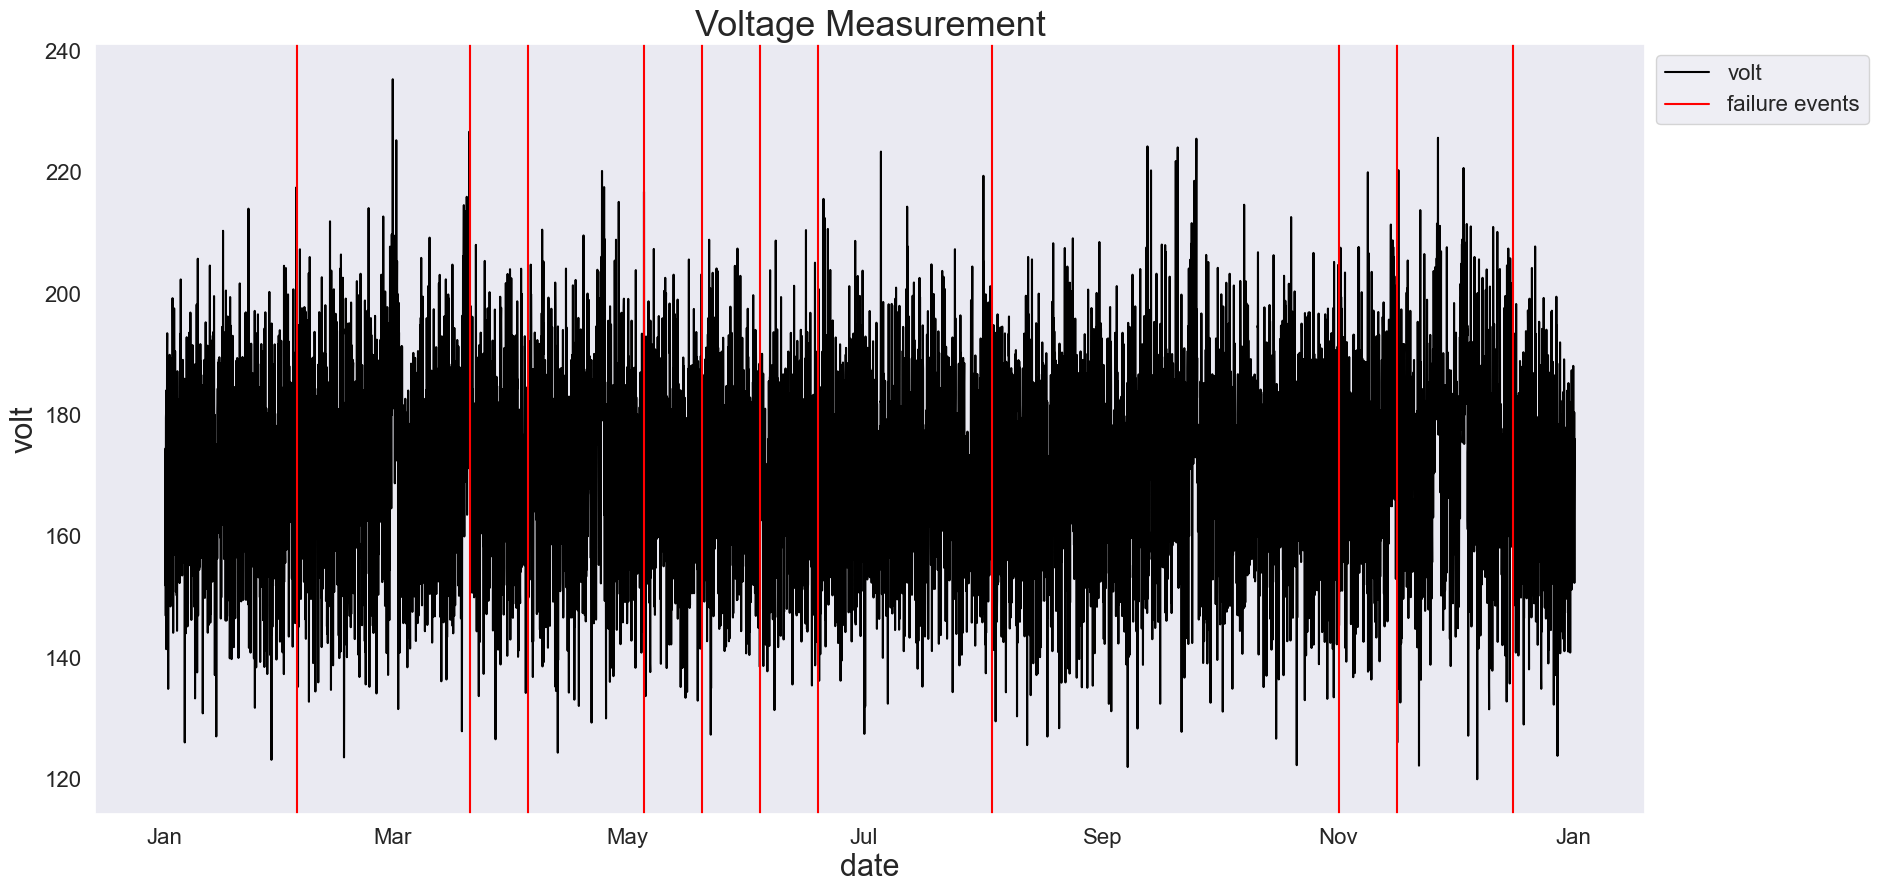

In [5]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(sen_data['datetime'], sen_data['volt'], color='black', label='volt')
ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
for dt in fail_dt['datetime'][1:]:
  ax.axvline(x=dt, color='red')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

From the plot above, we know that the vibration will be bigger when the last of the month. For the quick assumption, the anomaly of bearings' vibration may be happen mostly in last month.

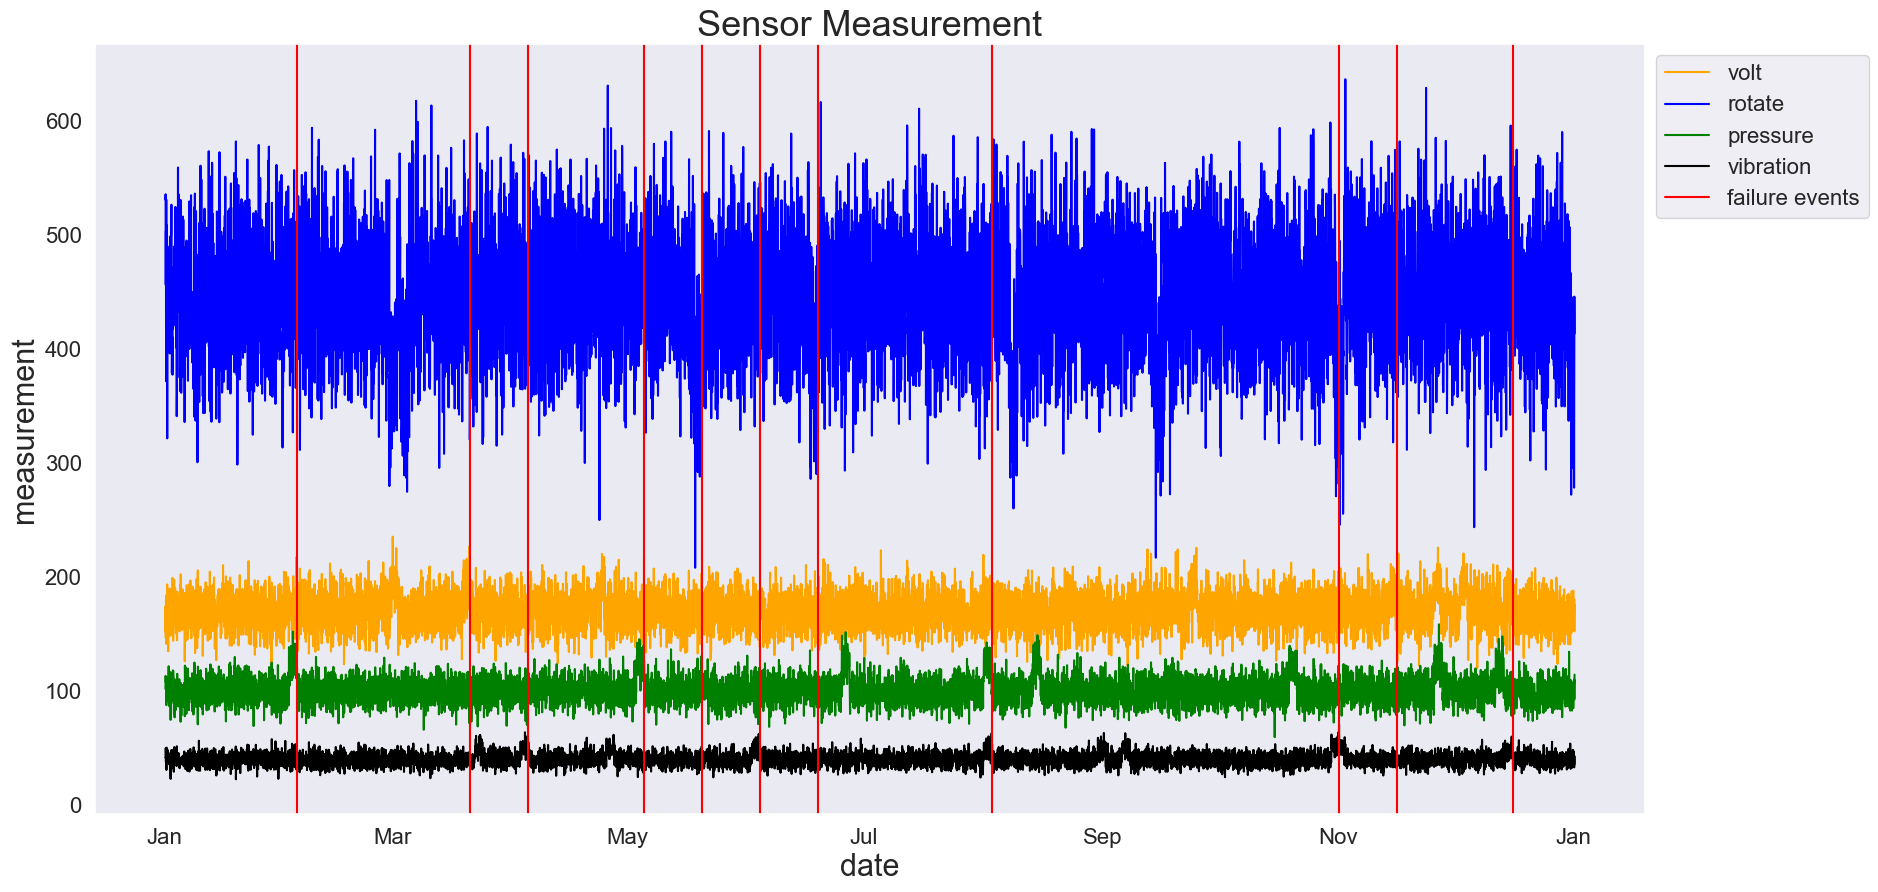

In [6]:
def plot_diagnostic_data(sen_data, fail_dt, predicted_fail_dt):
    fig, ax =  plt.subplots(figsize=(20,10))

    # Plot data
    ax.plot(sen_data['datetime'], sen_data['volt'], color='orange', label='volt')
    ax.plot(sen_data['datetime'], sen_data['rotate'], color='blue', label='rotate')
    ax.plot(sen_data['datetime'], sen_data['pressure'], color='green', label='pressure')
    ax.plot(sen_data['datetime'], sen_data['vibration'], color='black', label='vibration')

    ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
    for dt in fail_dt['datetime'][1:]:
        ax.axvline(x=dt, color='red')

    if type(predicted_fail_dt) != type(None):
        if predicted_fail_dt.empty != True:
            ax.axvline(x=predicted_fail_dt['datetime'][0], color='blue', label='predicted failure events', linestyle = '--')
            for dt in predicted_fail_dt['datetime'][1:]:
                ax.axvline(x=dt, color='blue', linestyle = '--')
        else: 
            print('\033[91m' + '\033[1m' + '-'*50 + 'EMPTY PREDICTED FAILURE DATA!' + '-'*50 + '\033[0m')

    # Format X axis - DateTime
    # date_form = DateFormatter("%m-%d")
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)

    plt.title("Sensor Measurement", fontsize = 26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("measurement", fontsize = 22)
    plt.grid()
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

plot_diagnostic_data(sen_data, fail_dt, None)

In [10]:
#Set training and testing data
#Selection of training data on that date based on a plot above that shows normal data
train_tp = pd.to_datetime("2015-06-01")
data_train = sen_data[sen_data['datetime'] <= train_tp]
train_data_fail = fail_dt[fail_dt['datetime'] <= train_tp]
data_test = sen_data[sen_data['datetime'] > train_tp]

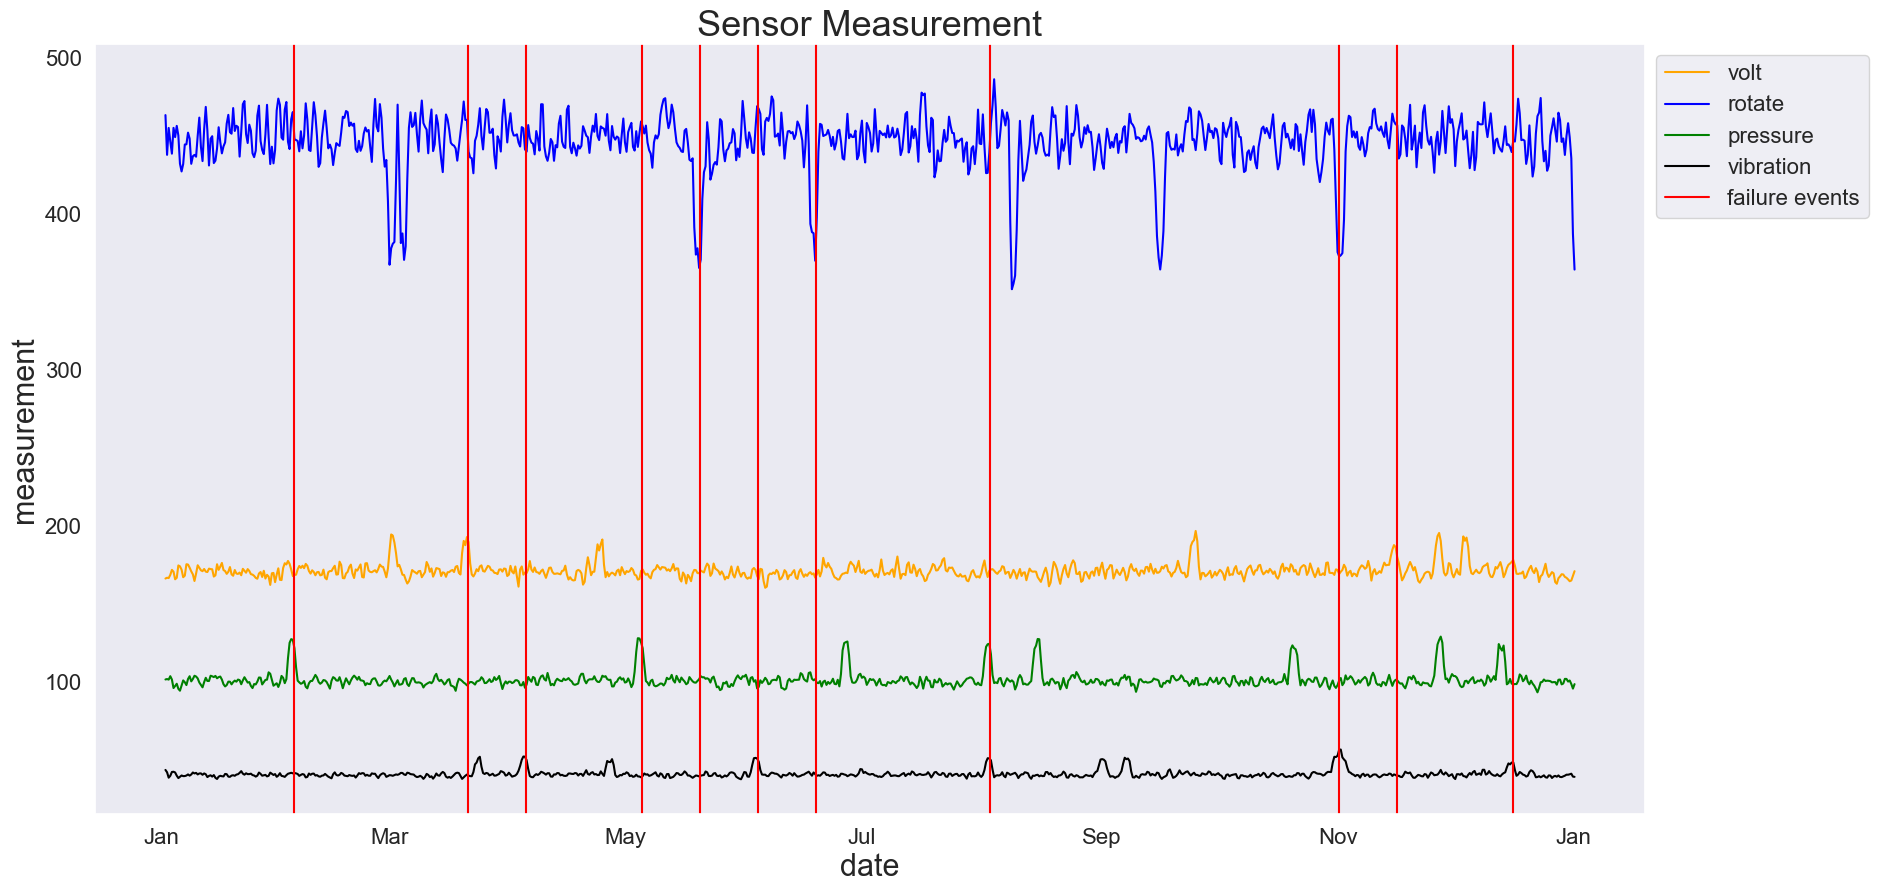

In [11]:
def sliding_mean(data, win_size, step_size=1):
    data_dict = {}
    for col_name in data.columns:
        data_dict[col_name] = []
    for col_name in data.columns:
        i = 0
        while i < (len(data)-win_size):
            if(col_name == 'datetime'):
                data_dict[col_name].append(data[col_name][i+win_size-1])
            else:   
                data_dict[col_name].append(data[col_name][i:i+win_size].mean())
            i += step_size
        
    return (pd.DataFrame(data_dict))

slide_mean_data = sliding_mean(sen_data, 20, 10)

plot_diagnostic_data(slide_mean_data, fail_dt, None)

In [13]:
data_train.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618],
           dtype='int64', length=3619)

In [15]:
type(data_train)

pandas.core.frame.DataFrame

In [12]:
#Define the function
#Normalize data

scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(data_train), 
                              columns=data_train.columns, 
                              index=data_train.index)

X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(data_test), 
                             columns=data_test.columns, 
                             index=data_test.index)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [17]:
#PCA to reduce the data dimension

from sklearn.decomposition import PCA
PCA = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = PCA.fit_transform(data_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = PCA.transform(data_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [ ]:
#Calculate the covariance matrix

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [ ]:
#Calculate Mahalanobis distance

def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [ ]:
#Detecting outliers

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [ ]:
#Calculate threshold

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [ ]:
#Check if matrix is positive definite

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
#Define PCA for training adn testing dataset

data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [ ]:
#calculate covariance matrix

cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [ ]:
#Calculate means for data training

mean = data_train.mean(axis=0)
mean

array([ 1.59314515e-17, -4.38114916e-17])

In [ ]:
#Calculate distance for training and testing dataset and calculate threshold to detect anomaly

distance_test = MahalanobisDist(inv_cov_matrix, mean, data_test, verbose=False)
distance_train = MahalanobisDist(inv_cov_matrix, mean, data_train, verbose=False)
threshold = MD_threshold(distance_train, extreme = True)

In [ ]:
threshold

2.4962025112400212

/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_97923/319815808.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distance_train,


Text(0.5, 0, 'Mahalanobis distance')

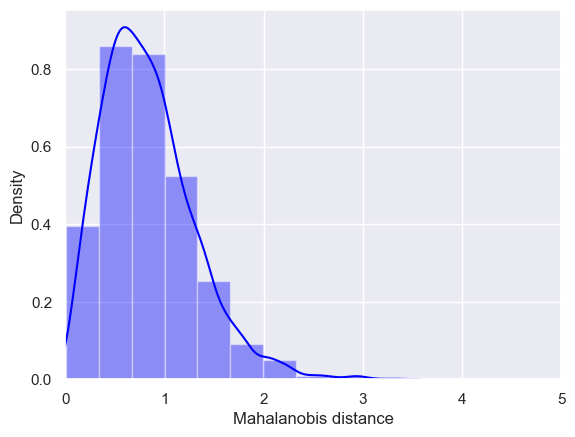

In [ ]:
plt.figure()
sns.distplot(distance_train,
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis distance')

It is proven that the day with Mahalanobis distance above 3 is outlier or anomaly.

In [ ]:
anomaly_train = pd.DataFrame()
anomaly_train['Mhb dist']= distance_train
anomaly_train['Thresh'] = threshold
# If Mahalanobis distance above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mhb dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mhb dist']= distance_test
anomaly['Thresh'] = threshold
# If Mahalanobisb distance above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mhb dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mhb dist,Thresh,Anomaly
datetime,,,
2015-06-01 00:00:00,0.860452,2.496203,False
2015-06-01 01:00:00,0.822105,2.496203,False
2015-06-01 02:00:00,1.797587,2.496203,False
2015-06-01 03:00:00,0.341120,2.496203,False
2015-06-01 04:00:00,0.738073,2.496203,False


In [ ]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

<AxesSubplot: xlabel='datetime'>

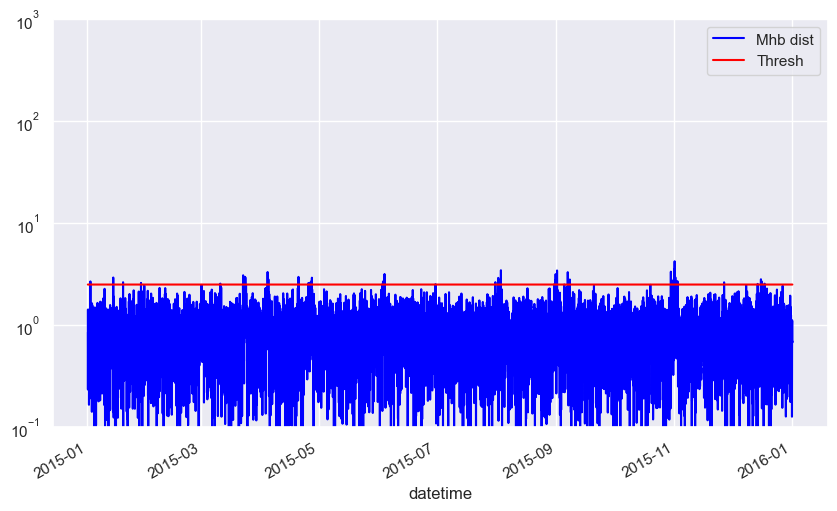

In [ ]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['blue','red'])

From the plot above proven that our quick assumption is true. The anomaly is occur almost in the last month, spesifically at 16th December 2004 afternoon.